**Predict MBTI Types**

Rio Ananda (22.11.5134)

M.Taufik Pratama (22.11.5169)

Adam Huzaini (22.11.5192)

Enggar Okta Pradana (22.11.5193)

In [ ]:
!pip install pyspark

# **Import Library**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml.feature import StringIndexer, VectorAssembler
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# **Preprocessing**

In [ ]:
spark = SparkSession.builder.appName('MBTI').getOrCreate()

In [ ]:
df = spark.read.csv('/content/data.csv', header = True, inferSchema = True)

df.printSchema()

root
 |-- Age: double (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Education: integer (nullable = true)
 |-- Introversion Score: double (nullable = true)
 |-- Sensing Score: double (nullable = true)
 |-- Thinking Score: double (nullable = true)
 |-- Judging Score: double (nullable = true)
 |-- Interest: string (nullable = true)
 |-- Personality: string (nullable = true)



In [ ]:
nilai_null = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])

nilai_null.show()

+---+------+---------+------------------+-------------+--------------+-------------+--------+-----------+
|Age|Gender|Education|Introversion Score|Sensing Score|Thinking Score|Judging Score|Interest|Personality|
+---+------+---------+------------------+-------------+--------------+-------------+--------+-----------+
|  0|     0|        0|                 0|            0|             0|            0|       0|          0|
+---+------+---------+------------------+-------------+--------------+-------------+--------+-----------+



In [ ]:
# df = df.dropna()

In [ ]:
string_col = ["Gender", "Interest", "Personality"]

indexers = {col_name: StringIndexer(inputCol=col_name, outputCol=f"{col_name}_Index").fit(df) for col_name in string_col}

for col_name, indexer in indexers.items():
  df = indexer.transform(df)

In [ ]:
df = df.drop(*string_col)

df.show(10)

+----+---------+------------------+------------------+--------------+------------------+------------+--------------+-----------------+
| Age|Education|Introversion Score|     Sensing Score|Thinking Score|     Judging Score|Gender_Index|Interest_Index|Personality_Index|
+----+---------+------------------+------------------+--------------+------------------+------------+--------------+-----------------+
|21.0|        1|           5.89208| 2.144394543565554|       7.32363| 5.462224378080117|         1.0|           1.0|              3.0|
|24.0|        1|           2.48366|3.2061882098459846|       8.06876|   3.7650121889863|         1.0|           0.0|             11.0|
|26.0|        1|            7.0291| 6.469302076081513|       4.16472| 5.454441760919251|         1.0|           3.0|              5.0|
|30.0|        0|           5.46525| 4.179243896067972|       2.82487| 5.080477122685776|         0.0|           2.0|              0.0|
|31.0|        0|           3.59804|6.1892586127938705| 

In [ ]:
df.describe().show()

+-------+------------------+-------------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+
|summary|               Age|          Education|Introversion Score|     Sensing Score|    Thinking Score|    Judging Score|       Gender_Index|    Interest_Index| Personality_Index|
+-------+------------------+-------------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+
|  count|             43744|              43744|             43744|             43744|             43744|            43744|              43744|             43744|             43744|
|   mean|27.437202816386247|0.22901426481346013| 4.588348527112293|    5.780073760471| 5.419130694723845|5.391040863837991|0.44780998536942207|1.5356391733723482|               7.5|
| stddev| 4.893805160320807|0.42020324580165286|2.9026282971330364|1.2416482966340825|2.90

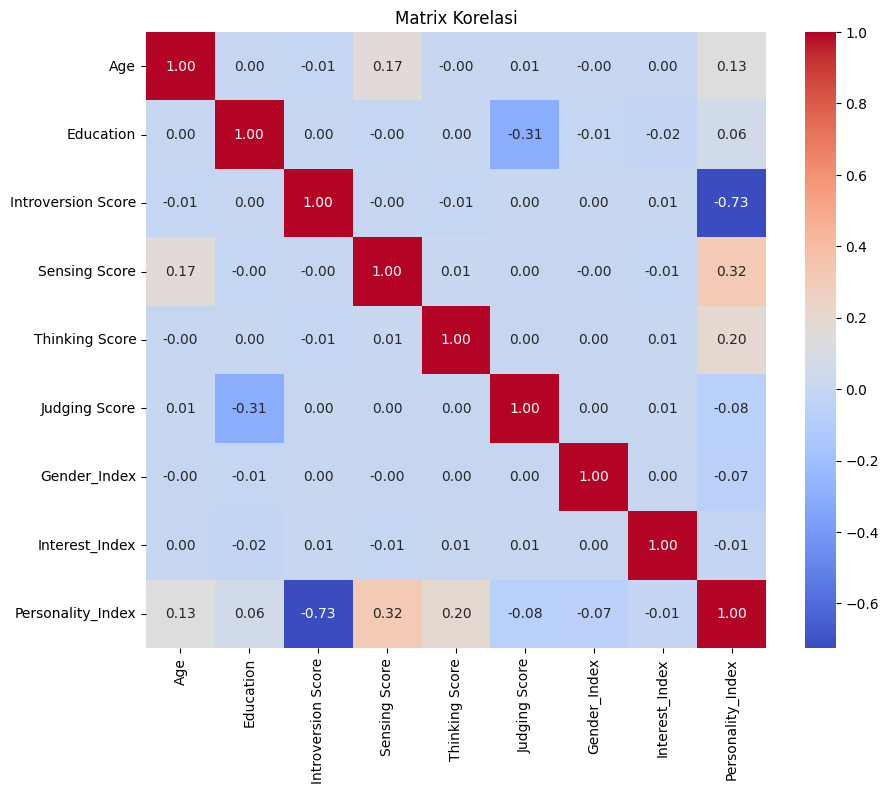

In [ ]:
pandas_df = df.toPandas()
correlation_matrix = pandas_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrix Korelasi")
plt.show()

# **EDA**

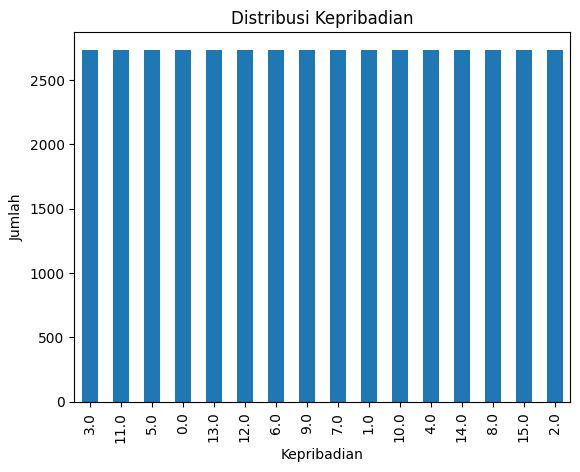

In [ ]:
personality = pandas_df["Personality_Index"].value_counts()

personality.plot(kind="bar", title="Distribusi Kepribadian")
plt.xlabel("Kepribadian")
plt.ylabel("Jumlah")
plt.show()

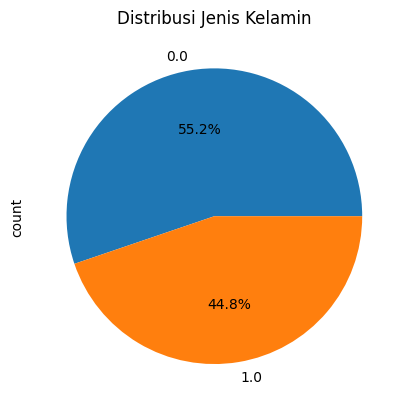

In [ ]:
gender = pandas_df["Gender_Index"].value_counts()

gender.plot(kind="pie", autopct="%1.1f%%", title="Distribusi Jenis Kelamin")
plt.show()

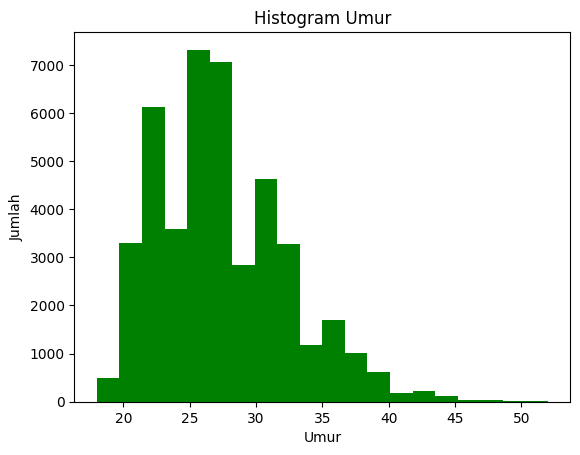

In [ ]:
pandas_df["Age"].plot(kind='hist', bins=20, color='green')

plt.title("Histogram Umur")
plt.xlabel("Umur")
plt.ylabel("Jumlah")
plt.show()

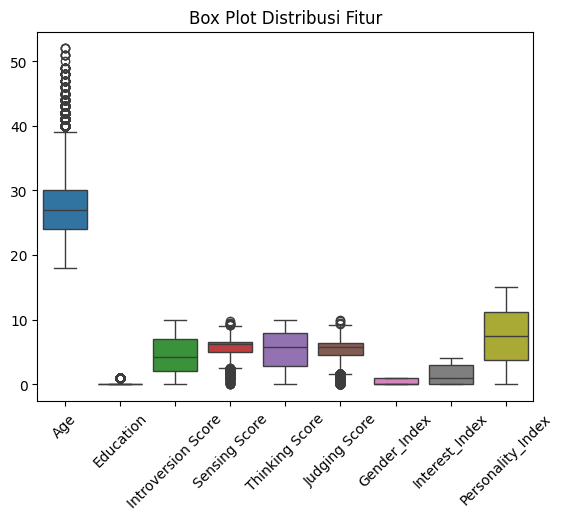

In [ ]:
sns.boxplot(data=pandas_df)
plt.title("Box Plot Distribusi Fitur")
plt.xticks(rotation=45)
plt.show()

# **Feature Selection**

In [ ]:
feature_cols = [col for col in pandas_df.columns if col != "Personality_Index" and col != "Interest_Index"]

print(feature_cols)

['Age', 'Education', 'Introversion Score', 'Sensing Score', 'Thinking Score', 'Judging Score', 'Gender_Index']


# **Modeling**

In [ ]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
spark_df = assembler.transform(df)

In [ ]:
spark_df.show(5)

+----+---------+------------------+------------------+--------------+------------------+------------+--------------+-----------------+--------------------+
| Age|Education|Introversion Score|     Sensing Score|Thinking Score|     Judging Score|Gender_Index|Interest_Index|Personality_Index|            features|
+----+---------+------------------+------------------+--------------+------------------+------------+--------------+-----------------+--------------------+
|21.0|        1|           5.89208| 2.144394543565554|       7.32363| 5.462224378080117|         1.0|           1.0|              3.0|[21.0,1.0,5.89208...|
|24.0|        1|           2.48366|3.2061882098459846|       8.06876|   3.7650121889863|         1.0|           0.0|             11.0|[24.0,1.0,2.48366...|
|26.0|        1|            7.0291| 6.469302076081513|       4.16472| 5.454441760919251|         1.0|           3.0|              5.0|[26.0,1.0,7.0291,...|
|30.0|        0|           5.46525| 4.179243896067972|       2.8

## **Random Forest**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="Personality_Index", numTrees=100, seed=42)
rf_model = rf_classifier.fit(train_data)

In [ ]:
rf_predictions = rf_model.transform(test_data)

## **Gradient Boosted Tree**

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import OneVsRest

In [ ]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
spark_df = assembler.transform(df)

In [ ]:
X_train, X_test = spark_df.randomSplit([0.8, 0.2], seed=42)

gbt = GBTClassifier(featuresCol="features", labelCol="Personality_Index", maxIter=50, seed=42)

In [ ]:
ovr = OneVsRest(classifier=gbt, labelCol="Personality_Index")

ovr_model = ovr.fit(X_train)

In [ ]:
gbt_predictions = ovr_model.transform(X_test)

## **Logistic Regression**

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
train_df, test_df = spark_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
lr = LogisticRegression(featuresCol="features", labelCol="Personality_Index")
lr_model = lr.fit(train_df)

In [ ]:
lr_predictions = lr_model.transform(test_df)

## **Neural Networks**

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [ ]:
nn_X_train, nn_X_test = spark_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
nn_layers = [len(feature_cols), 16, 8, df.select("Personality_Index").distinct().count()]

In [ ]:
nn_mlp = MultilayerPerceptronClassifier(featuresCol="features", labelCol="Personality_Index", layers=nn_layers, seed=42, maxIter=100)

In [ ]:
nn_model = nn_mlp.fit(nn_X_train)

In [ ]:
nn_predictions = nn_model.transform(nn_X_test)

# **Model Evaluation**

In [ ]:
rf_predictions.show(5)
gbt_predictions.show(5)
lr_predictions.show(5)
nn_predictions.show(5)

+----+---------+------------------+-----------------+--------------+------------------+------------+--------------+-----------------+--------------------+--------------------+--------------------+----------+
| Age|Education|Introversion Score|    Sensing Score|Thinking Score|     Judging Score|Gender_Index|Interest_Index|Personality_Index|            features|       rawPrediction|         probability|prediction|
+----+---------+------------------+-----------------+--------------+------------------+------------+--------------+-----------------+--------------------+--------------------+--------------------+----------+
|18.0|        0|           0.45001| 5.55136404399402|       8.01111|6.0771914136854654|         1.0|           4.0|             10.0|[18.0,0.0,0.45001...|[0.40530708751150...|[0.00405307087511...|      10.0|
|18.0|        0|           0.63338|5.489312561581086|       9.38111|3.0810828707411395|         1.0|           1.0|             11.0|[18.0,0.0,0.63338...|[0.07063647324

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [ ]:
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="Personality_Index", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Personality_Index", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="Personality_Index", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="Personality_Index", predictionCol="prediction", metricName="weightedRecall")

In [ ]:
predictions = [
  (rf_predictions, "Random Forest"),
  (gbt_predictions, "Gradient Boosted Tree"),
  (lr_predictions, "Logistic Regression"),
  (nn_predictions, "Neural Network")
]

In [ ]:
evaluations = []

for prediction, name in predictions:
  accuracy = evaluator_accuracy.evaluate(prediction)
  f1_score = evaluator_f1.evaluate(prediction)
  precision = evaluator_precision.evaluate(prediction)
  recall = evaluator_recall.evaluate(prediction)

  evaluations.append((name, accuracy, f1_score, precision, recall))

In [ ]:
for evaluation in evaluations:
  print(f"{evaluation[0]}:")
  print(f"  Accuracy: {evaluation[1]:.4f}")
  print(f"  F1 Score: {evaluation[2]:.4f}")
  print(f"  Precision: {evaluation[3]:.4f}")
  print(f"  Recall: {evaluation[4]:.4f}\n")

Random Forest:
  Accuracy: 0.7729
  F1 Score: 0.7718
  Precision: 0.7825
  Recall: 0.7729

Gradient Boosted Tree:
  Accuracy: 0.8078
  F1 Score: 0.8076
  Precision: 0.8109
  Recall: 0.8078

Logistic Regression:
  Accuracy: 0.7795
  F1 Score: 0.7794
  Precision: 0.7804
  Recall: 0.7795

Neural Network:
  Accuracy: 0.4962
  F1 Score: 0.4644
  Precision: 0.4941
  Recall: 0.4962



# **Hyperparameter Tuning**

In [ ]:
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

## **Gradient Boosted Tree**

In [ ]:
gbt_param_grid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [3, 5])\
  .addGrid(gbt.maxIter, [50])\
  .addGrid(gbt.stepSize, [0.1])\
  .build()

gbt_tvs = TrainValidationSplit(
  estimator=ovr,
  estimatorParamMaps=gbt_param_grid,
  evaluator=MulticlassClassificationEvaluator(labelCol="Personality_Index", predictionCol="prediction", metricName="accuracy"),
  trainRatio=0.8
)

In [ ]:
gbt_tvs_model = gbt_tvs.fit(X_train)

In [ ]:
gbt_model_terbaik = gbt_tvs_model.bestModel

## **Logistic Regression**

In [ ]:
lr_param_grid = ParamGridBuilder()\
  .addGrid(lr.maxIter, [50, 100])\
  .addGrid(lr.regParam, [0.0, 0.1])\
  .build()

lr_tvs = TrainValidationSplit(
  estimator=lr,
  estimatorParamMaps=lr_param_grid,
  evaluator=MulticlassClassificationEvaluator(labelCol="Personality_Index", predictionCol="prediction", metricName="accuracy"),
  trainRatio=0.8
)

In [ ]:
lr_tvs_model = lr_tvs.fit(train_df)

In [ ]:
lr_model_terbaik = lr_tvs_model.bestModel

# **Evaluasi Model Terbaik**

In [ ]:
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="Personality_Index", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Personality_Index", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="Personality_Index", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="Personality_Index", predictionCol="prediction", metricName="weightedRecall")

gbt_predictions = gbt_model_terbaik.transform(test_df)
lr_predictions = lr_model_terbaik.transform(test_df)

gbt_accuracy = evaluator_accuracy.evaluate(gbt_predictions)
gbt_f1 = evaluator_f1.evaluate(gbt_predictions)
gbt_precision = evaluator_precision.evaluate(gbt_predictions)
gbt_recall = evaluator_recall.evaluate(gbt_predictions)

lr_accuracy = evaluator_accuracy.evaluate(lr_predictions)
lr_f1 = evaluator_f1.evaluate(lr_predictions)
lr_precision = evaluator_precision.evaluate(lr_predictions)
lr_recall = evaluator_recall.evaluate(lr_predictions)

print("Gradient Boosted Tree:")
print(f"  Accuracy: {gbt_accuracy:.4f}")
print(f"  F1 Score: {gbt_f1:.4f}")
print(f"  Precision: {gbt_precision:.4f}")
print(f"  Recall: {gbt_recall:.4f}")

print("\nLogistic Regression:")
print(f"  Accuracy: {lr_accuracy:.4f}")
print(f"  F1 Score: {lr_f1:.4f}")
print(f"  Precision: {lr_precision:.4f}")
print(f"  Recall: {lr_recall:.4f}")

Gradient Boosted Tree:
  Accuracy: 0.8078
  F1 Score: 0.8076
  Precision: 0.8109
  Recall: 0.8078

Logistic Regression:
  Accuracy: 0.7793
  F1 Score: 0.7791
  Precision: 0.7801
  Recall: 0.7793
